Imports

In [378]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import collections
%matplotlib inline

import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from time import time
from scipy import ndimage
from sklearn import manifold

import warnings
warnings.filterwarnings('ignore')

In [379]:
original_dataset = pd.read_csv('LoL_Dataset_Large.csv')
del original_dataset['duration']
original_dataset.head()

,attack_winner1,defense_winner1,difficulty_winner1,magic_winner1,armor_winner1,armorperlevel_winner1,attackdamage_winner1,attackdamageperlevel_winner1,attackrange_winner1,attackspeedoffset_winner1,...,hpperlevel_loser5,hpregen_loser5,hpregenperlevel_loser5,movespeed_loser5,mp_loser5,mpperlevel_loser5,mpregen_loser5,mpregenperlevel_loser5,spellblock_loser5,spellblockperlevel_loser5
0,7,5,6,6,24.880,3.5,59.180,3.50,125.0,-0.020,...,80.0,6.255,0.60,325.0,384.0,47.0,6.00,0.8,30.0,0.00
1,10,1,8,1,19.012,3.4,55.880,1.66,550.0,-0.050,...,82.0,5.840,0.50,325.0,245.6,45.0,6.68,1.0,30.0,0.00
2,3,4,5,8,20.880,3.5,53.040,3.00,550.0,-0.065,...,86.0,7.000,0.55,340.0,400.0,50.0,6.00,0.8,30.0,0.00
3,8,5,3,2,24.880,3.5,59.876,3.20,175.0,-0.050,...,83.0,5.620,0.55,335.0,374.0,50.0,8.50,0.8,30.0,0.00
4,7,6,4,8,26.048,3.6,53.040,3.00,150.0,0.000,...,85.0,8.340,0.65,350.0,200.0,0.0,50.00,0.0,32.1,1.25


Averaging champion abilities for each team

In [380]:
mean_winners = np.zeros([len(original_dataset),24])
mean_winners_pow2 = np.zeros([len(original_dataset),24])
for i in range(0,5):
    mean_winners += original_dataset.ix[:,i*24:i*24+24] / 5
    mean_winners_pow2 += original_dataset.ix[:,i*24:i*24+24]*original_dataset.ix[:,i*24:i*24+24] / 5
std_winners = mean_winners_pow2 - mean_winners * mean_winners

mean_losers = np.zeros([len(original_dataset),24])
mean_losers_pow2 = np.zeros([len(original_dataset),24])
for i in range(5,10):
    mean_losers += original_dataset.ix[:,i*24:i*24+24] / 5
    mean_losers_pow2 += original_dataset.ix[:,i*24:i*24+24] * original_dataset.ix[:,i*24:i*24+24] / 5
std_losers = mean_losers_pow2 - mean_losers * mean_losers

In [381]:
dt = np.concatenate((mean_winners, std_winners, mean_losers, std_losers), axis=1)
names = original_dataset.columns[0:24]
dataset = pd.DataFrame(data=dt, columns=['mean_'+s[:-1] for s in names] + ['std_'+s[:-8]+'_winner' for s in names] + ['mean_'+s[:-8]+'_loser' for s in names] + ['std_'+s[:-1]+'_loser' for s in names])

Deleting rows with NaN values

In [382]:
to_be_deleted = []
for idx,item in enumerate(dataset.as_matrix()):
    if np.isnan(item).any():
        to_be_deleted.append(idx)
dataset = dataset.drop(to_be_deleted)

In [383]:
dataset = dataset.sample(n=10000, replace=False)

In [384]:
dataset.head()

,mean_attack_winner,mean_defense_winner,mean_difficulty_winner,mean_magic_winner,mean_armor_winner,mean_armorperlevel_winner,mean_attackdamage_winner,mean_attackdamageperlevel_winner,mean_attackrange_winner,mean_attackspeedoffset_winner,...,std_hpperlevel_winner_loser,std_hpregen_winner_loser,std_hpregenperlevel_winner_loser,std_movespeed_winner_loser,std_mp_winner_loser,std_mpperlevel_winner_loser,std_mpregen_winner_loser,std_mpregenperlevel_winner_loser,std_spellblock_winner_loser,std_spellblockperlevel_winner_loser
96734,5.4,3.6,5.4,5.2,23.5612,3.34,56.88880,2.867,366.0,-0.02544,...,11.76,1.642756,0.0036,86.0,148.228096,61.44,0.540604,0.0194,1.0584,0.375
53376,6.8,5.4,5.0,3.6,25.1444,3.43,58.35920,3.122,220.0,-0.03344,...,19.04,1.581450,0.0116,64.0,9227.342336,490.56,316.278560,0.0754,1.0584,0.375
50870,6.2,3.4,7.8,5.8,22.4632,3.34,54.87600,2.932,375.0,-0.03600,...,26.96,0.945040,0.0060,84.0,9060.436096,248.56,10.193216,0.0774,1.0584,0.375
93758,6.0,4.6,5.6,4.8,23.4016,3.22,55.95600,2.882,305.0,-0.02900,...,9.44,0.986060,0.0040,56.0,2245.922496,119.76,4.330816,0.0234,1.0584,0.375
13463,4.0,5.0,7.2,6.8,20.7368,3.48,56.25272,2.976,450.0,0.00000,...,2.16,1.484274,0.0046,76.0,2183.225856,321.04,287.500240,0.1004,0.7056,0.250


Adding label and swapping 50% of winners and losers

In [385]:
dataset['label'] = np.zeros([len(dataset),1])
middle = int((dataset.shape[1]-1)/2)
dt = dataset.as_matrix()
idx = np.random.choice(len(dataset), int(len(dataset)/2), replace=False)
tmp = dt[idx,middle:-1]
dt[idx,middle:-1] = dt[idx,:middle]
dt[idx,:middle] = tmp
dt[idx,-1] = 1
dataset = pd.DataFrame(data=dt, columns=dataset.columns)

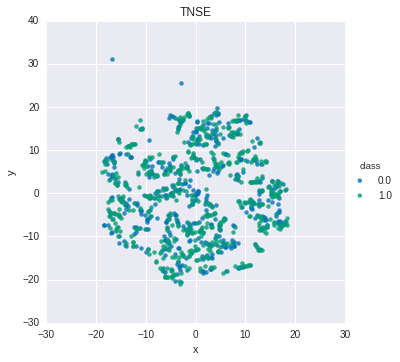

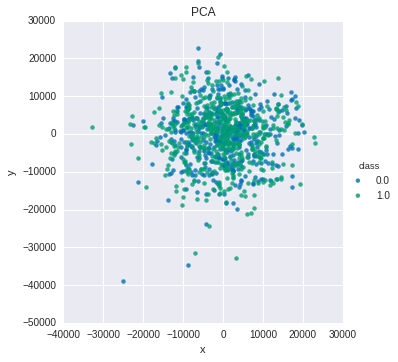

In [386]:
plot_data(dataset)

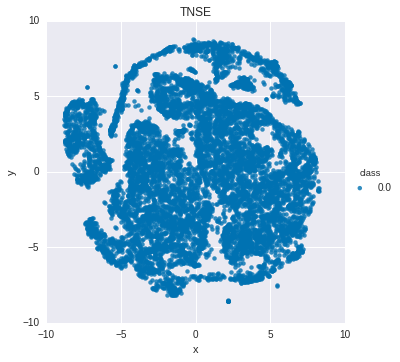

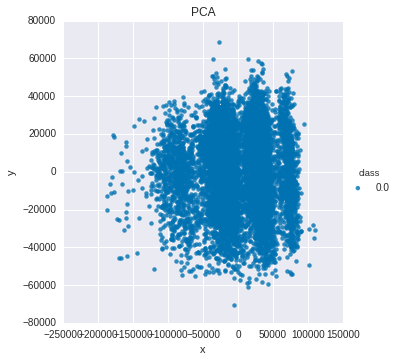

In [229]:
plot_data(dataset)

In [208]:
dataset.head()

,mean_attack_winner,mean_defense_winner,mean_difficulty_winner,mean_magic_winner,mean_armor_winner,mean_armorperlevel_winner,mean_attackdamage_winner,mean_attackdamageperlevel_winner,mean_attackrange_winner,mean_attackspeedoffset_winner,...,std_hpperlevel_loser,std_hpregen_loser,std_hpregenperlevel_loser,std_movespeed_loser,std_mp_loser,std_mpperlevel_loser,std_mpregen_loser,std_mpregenperlevel_loser,std_spellblock_loser,label
72081,5.2,4.0,6.4,5.4,23.3800,3.76,52.8552,2.876,390.0,0.008000,...,-47.955249,0.1824,-112560.0,-89116.328576,-1458.99,-46.713609,0.2356,-945.9276,0.1875,0.0
53260,5.8,4.8,4.4,5.8,23.9376,3.62,54.6168,3.342,385.0,-0.017000,...,-41.429936,0.2139,-116622.0,-42279.334400,-524.16,-184.574025,0.2304,-971.9424,0.0000,0.0
4429,6.0,4.0,6.0,4.2,24.2624,3.12,57.3504,2.962,295.0,-0.031468,...,-45.623529,0.2211,-116622.0,-90429.862656,-1607.76,-47.111924,0.2356,-945.9276,0.1875,0.0
18922,3.8,5.0,6.6,7.0,20.8384,2.92,51.8924,2.587,481.0,0.060000,...,-33.832244,0.2419,-109892.0,-79401.972656,-1346.64,-33.750561,0.2464,-894.9564,0.1875,0.0
70904,6.8,4.4,5.4,4.4,24.2120,3.33,55.1496,2.934,315.0,0.000000,...,-31.774281,0.2275,-111890.0,-108380.290944,-1738.64,-55.148249,0.2211,-920.2656,0.2500,0.0


Normalize the dataset

In [387]:
original_dataset = dataset

In [388]:
# MIN MAX Normalization
#x = dataset.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#dataset = pd.DataFrame(x_scaled)

In [389]:
# Standard Normalization (x-mean(x) / std(x))
x = dataset.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled, columns=dataset.columns)

In [390]:
dataset['label'] = original_dataset['label']

In [391]:
np.mean(dataset)

mean_attack_winner                       8.240297e-16
mean_defense_winner                      3.687384e-16
mean_difficulty_winner                   4.331535e-16
mean_magic_winner                        5.527578e-16
mean_armor_winner                       -1.456213e-15
mean_armorperlevel_winner                4.481637e-16
mean_attackdamage_winner                 1.850531e-15
mean_attackdamageperlevel_winner        -1.057052e-15
mean_attackrange_winner                 -2.104539e-16
mean_attackspeedoffset_winner           -3.659295e-17
mean_attackspeedperlevel_winner          1.926792e-17
mean_crit_winner                         0.000000e+00
mean_critperlevel_winner                 0.000000e+00
mean_hp_winner                           4.750889e-15
mean_hpperlevel_winner                   8.845991e-15
mean_hpregen_winner                     -3.804984e-16
mean_hpregenperlevel_winner              6.894312e-16
mean_movespeed_winner                    1.274622e-14
mean_mp_winner              

In [392]:
np.std(dataset)

mean_attack_winner                       1.0
mean_defense_winner                      1.0
mean_difficulty_winner                   1.0
mean_magic_winner                        1.0
mean_armor_winner                        1.0
mean_armorperlevel_winner                1.0
mean_attackdamage_winner                 1.0
mean_attackdamageperlevel_winner         1.0
mean_attackrange_winner                  1.0
mean_attackspeedoffset_winner            1.0
mean_attackspeedperlevel_winner          1.0
mean_crit_winner                         0.0
mean_critperlevel_winner                 0.0
mean_hp_winner                           1.0
mean_hpperlevel_winner                   1.0
mean_hpregen_winner                      1.0
mean_hpregenperlevel_winner              1.0
mean_movespeed_winner                    1.0
mean_mp_winner                           1.0
mean_mpperlevel_winner                   1.0
mean_mpregen_winner                      1.0
mean_mpregenperlevel_winner              1.0
mean_spell

In [394]:
dataset.head()

,mean_attack_winner,mean_defense_winner,mean_difficulty_winner,mean_magic_winner,mean_armor_winner,mean_armorperlevel_winner,mean_attackdamage_winner,mean_attackdamageperlevel_winner,mean_attackrange_winner,mean_attackspeedoffset_winner,...,std_hpregen_winner_loser,std_hpregenperlevel_winner_loser,std_movespeed_winner_loser,std_mp_winner_loser,std_mpperlevel_winner_loser,std_mpregen_winner_loser,std_mpregenperlevel_winner_loser,std_spellblock_winner_loser,std_spellblockperlevel_winner_loser,label
0,-0.039262,-1.198339,1.139362,1.827924,-0.614095,-0.066868,-1.267889,-0.654731,0.663265,-0.335492,...,-0.078544,-0.402456,-0.887055,-0.737987,-0.996582,-0.567150,-1.238567,0.493143,0.483169,1.0
1,1.159958,1.078303,-0.675992,-1.707883,1.225429,0.101539,1.427103,0.524884,-1.815608,-0.764925,...,-0.051459,-0.184242,0.121274,0.298809,1.417177,1.865088,0.217285,0.493143,0.483169,0.0
2,1.879490,-0.060018,-0.449073,-2.149859,0.978916,0.741484,1.282100,-0.088308,-0.616153,-1.108835,...,-0.240488,-0.591575,0.860716,-0.845427,-1.216551,-0.544034,-0.913983,0.493143,0.483169,1.0
3,0.200582,-0.060018,0.004765,-0.381956,-0.251955,-0.605769,0.044277,-0.722286,-0.456226,-0.562946,...,-0.623030,-0.460647,-0.147613,-0.741597,-0.684998,-0.538591,-1.023769,0.493143,0.483169,0.0
4,1.399802,-0.060018,-0.675992,-1.486895,0.285492,0.404671,1.691792,0.005230,-1.655680,-0.335492,...,2.290375,7.045911,-0.887055,-0.773293,-0.850541,-0.540359,-0.999903,-1.624653,-1.635064,1.0


In [287]:
# %load plot_data.py
# Omid55
def plot_data(data):
	import numpy as np
	from sklearn.manifold import TSNE
	from sklearn.decomposition import PCA

	LIMIT = 1000
	if data.shape[0] > LIMIT:
		dt = data.sample(n=LIMIT, replace=False)
		X = dt.ix[:,:-1]
		labels = dt.ix[:,-1]
	else:
		X = data.ix[:,:-1]
		labels = data.ix[:,-1]

	tsne_model = TSNE(n_components=2, random_state=0)
	np.set_printoptions(suppress=True)
	points1 = tsne_model.fit_transform(X)
	df1 = pd.DataFrame(data=np.column_stack([points1,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df1, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('TNSE')

	pca = PCA(n_components=2)
	pca.fit(X)
	points2 = pca.transform(X)
	df2 = pd.DataFrame(data=np.column_stack([points2,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df2, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('PCA')



Now dataset is ready for classification

In [115]:
# %load do_classification.py
#Omid55
def do_classification(dataset, verbose=True):
    
    if type(dataset) is pd.core.frame.DataFrame:
        dataset = dataset.as_matrix()

    #clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    models = [(LogisticRegression(), 'Logistic Regression'),
        (GaussianNB(), 'Naive Bayes'),
        (svm.LinearSVC(C=1.0, verbose=False), 'Linear SVM'),
        (svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False), 'SVM with RBF kernel'),
        (RandomForestClassifier(n_estimators=100), 'Random Forest'),
        (KNeighborsClassifier(n_neighbors=8), 'KNN'),
        (DecisionTreeClassifier(max_depth=5), 'Decision Tree'),
        (AdaBoostClassifier(), 'AdaBoost'),
        (LinearDiscriminantAnalysis(), 'Linear Discriminant Analysis'),
        (QuadraticDiscriminantAnalysis(), 'Quadratic Discriminant Analysis')]
    
    # applying the models
    n_folds = 10
    k_fold = cross_validation.KFold(n=len(dataset), n_folds=n_folds, shuffle=False, random_state=None)
    accuracy = {}
    for train_index, test_index in k_fold:
        X_train = dataset[train_index,:-1]
        y_train = dataset[train_index,-1]
        X_test = dataset[test_index,:-1]
        y_test = dataset[test_index,-1]

        for clf, name in models:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy_percent = 100 * sk.metrics.accuracy_score(y_test, y_pred) / n_folds
            if name not in accuracy:
                accuracy[name] = accuracy_percent
            else:
                accuracy[name] += accuracy_percent
    if verbose:
        for key, value in accuracy.items():
            print(key, ':', round(value,2))
    return accuracy


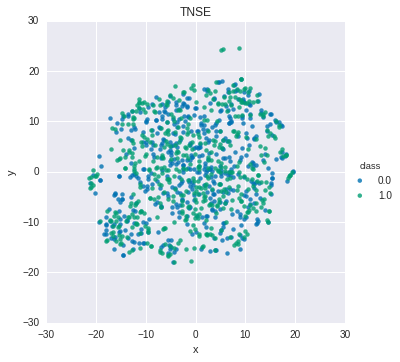

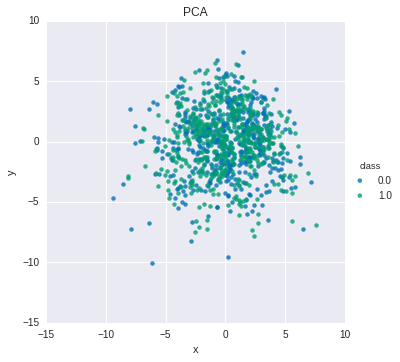

In [395]:
plot_data(dataset)

In [396]:
#standard normalization2
do_classification(dataset.as_matrix())

Logistic Regression : 52.22
AdaBoost : 51.8
Decision Tree : 50.25
Linear SVM : 52.3
SVM with RBF kernel : 51.44
Quadratic Discriminant Analysis : 49.32
KNN : 50.29
Linear Discriminant Analysis : 52.24
Random Forest : 50.9
Naive Bayes : 50.96


{'AdaBoost': 51.799999999999997,
 'Decision Tree': 50.25,
 'KNN': 50.290000000000006,
 'Linear Discriminant Analysis': 52.240000000000002,
 'Linear SVM': 52.300000000000004,
 'Logistic Regression': 52.220000000000006,
 'Naive Bayes': 50.959999999999994,
 'Quadratic Discriminant Analysis': 49.320000000000007,
 'Random Forest': 50.900000000000006,
 'SVM with RBF kernel': 51.440000000000005}

# Hierarchical Clustering

In [397]:
# since heirachical clustering needs to compute all samples 2 by 2 we have to resample the dataset
dtt = dataset.sample(n=4000, replace=False)
X = np.asmatrix(dtt.ix[:,:-1])
y = np.asanyarray(dtt['label'])
n_samples, n_features = X.shape

Computing embedding
Done.
ward : 16.12s
average : 16.29s
complete : 16.00s


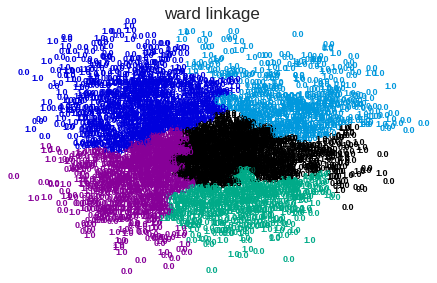

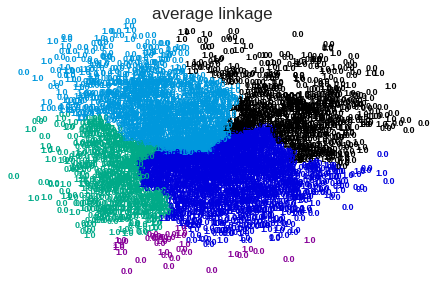

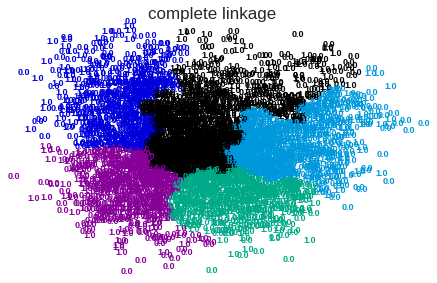

In [398]:
NUMBER_OF_CLUSTERS = 5

#----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))
    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

plt.show()

In [399]:
for linkage in ('ward', 'average', 'complete'):
    accuracies = collections.defaultdict(lambda: 0)
    print('Linkage is', linkage, '=>\n\n')
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    clustering.fit(X_red)
    for cluster_index in range(NUMBER_OF_CLUSTERS):
        idx = np.where(clustering.labels_==cluster_index)[0]
        print('Length of this cluster is:', len(idx),'\n')
        if len(idx) > 20:
            accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=True)
            print('\n----------------------------------------------\n')
#         for k, v in accuracy.items():
#             accuracies[k] += v / float(NUMBER_OF_CLUSTERS)
#     print('Average classification accuracy on clusters is:')
#     for key, value in accuracies.items():
#         print(key, ':', round(value,2))
    print('\n\n\n================================================')

Linkage is ward =>


Length of this cluster is: 1184 

Logistic Regression : 47.2
AdaBoost : 50.09
Decision Tree : 47.8
Linear SVM : 47.2
SVM with RBF kernel : 48.81
Quadratic Discriminant Analysis : 51.6
KNN : 49.67
Linear Discriminant Analysis : 46.86
Random Forest : 50.58
Naive Bayes : 49.42

----------------------------------------------

Length of this cluster is: 862 

Logistic Regression : 48.25
AdaBoost : 46.41
Decision Tree : 49.65
Linear SVM : 48.02
SVM with RBF kernel : 50.11
Quadratic Discriminant Analysis : 53.24
KNN : 50.22
Linear Discriminant Analysis : 47.79
Random Forest : 49.66
Naive Bayes : 52.9

----------------------------------------------

Length of this cluster is: 926 

Logistic Regression : 53.67
AdaBoost : 51.07
Decision Tree : 49.37
Linear SVM : 52.37
SVM with RBF kernel : 52.7
Quadratic Discriminant Analysis : 49.26
KNN : 48.59
Linear Discriminant Analysis : 52.16
Random Forest : 52.28
Naive Bayes : 53.14

----------------------------------------------

Len